# Micrograd

A tiny autograd engine. Implements backpropagation (reverse-mode autodiff) over a dynamically built DAG and a small neural networks library on top of it with a PyTorch-like API

In [2]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import torch

%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 1

In [4]:
f(3.0)

16.0

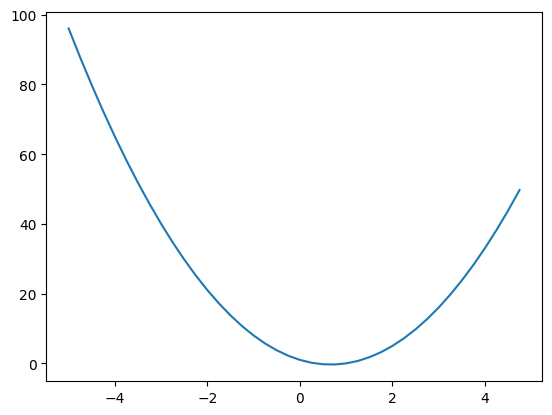

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
h = 0.00001
x = 3.0
(f(x + h) - f(x)) / h

14.00003000000538

To further understand the intuition of what a derivative is telling us we can look at a slightly more complex example. Here is an expression, with three components `a`, `b`, `c` with one output `d`. When we derive `d` WRT to each of it's components we can further understand how the derivative affects the outcome

In [7]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [8]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

# derivative of d with respect to an input a, b, or c
c += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
# (d2 - d1) is how much the output changes when we increase a by h
# (d2 - d1) / h is the slope of the output with respect to the input, via normalization
print('slope', (d2 - d1) / h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [9]:
def trace(root):
    # Builds a set of all nodes and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        nodes.add(v)
        for child in v.prev:
            edges.add((child, v))
            build(child)
    build(root)
    return nodes, edges

In [10]:
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any value in the graph, create a rectangular ('record') node for it
        dot.node(uid, label="{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad, ), shape='record')
        if n.op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name=uid+n.op, label=n.op)
            # Connect this node to it
            dot.edge(uid+n.op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)
    return dot

In [11]:
class Value:
    """
    Stores a single scalar value and its gradient
    """

    def __init__(self, _data, _children=(), _op='', label=''):
        self.data = _data
        # At initialization gradient is 0.0, meaning no impact on the final output (loss function)
        self.grad = 0.0
        # internal variables used for autograd construction
        self._backward = lambda: None
        self.prev = set(_children)
        # the op that produced this node, for graphviz and debugging
        self.op = _op
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad

        out._backward = _backward
        return out
    
    def __radd__(self, other): # other + self
        return self.__add__(other)
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __rsub__(self, other): # other - self
        return self.__sub__(other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other * self
        return self.__mul__(other)
    
    def __neg__(self):
        return self * -1

    def __truediv__(self, other):
        return self * other**-1
    
    def __rtruediv__(self, other): # other / self
        return self.__truediv__(other)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float for now"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += other * self.data**(other-1) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        # Initialize the gradient of the final value to 1.0
        self.grad = 1.0
        # Traverse the graph in reverse topological order
        topo = []
        visited = set()
        def build(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    build(child)
                topo.append(v)
        build(self)
        # Traverse the graph in the reverse order and accumulate the gradients
        for v in reversed(topo):
            v._backward()
    
    def __repr__(self):
        return f"Value(data={self.data})"


In [12]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a*b; d.label = 'd'
L = d + c; L.label = 'L'

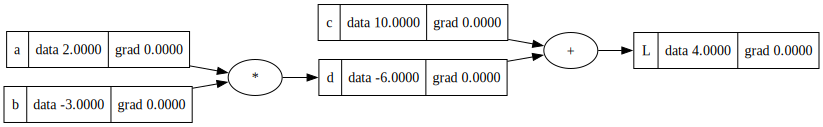

In [13]:
draw_dot(L)

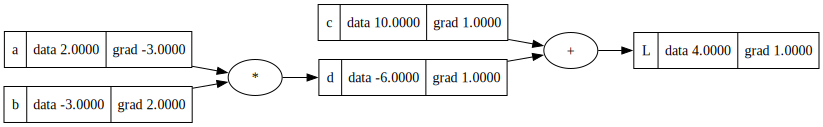

In [14]:
L.backward()
draw_dot(L)

To see how this is done with PyTorch, the library you would use in production when building neural networks

In [15]:
a = torch.Tensor([2.0]).double(); a.requires_grad = True
b = torch.Tensor([-3.0]).double(); b.requires_grad = True
c = torch.Tensor([10.0]).double(); c.requires_grad = True
d = a*b; d.label = 'd'
L = d + c; L.label = 'L'

print('L.data', L.data.item())
L.backward()
print('----------------')
print('a.grad', a.grad.item())
print('b.grad', b.grad.item())
print('c.grad', c.grad.item())

L.data 4.0
----------------
a.grad -3.0
b.grad 2.0
c.grad 1.0


## Building a Neural Network Library

In [16]:
class Neuron:
    def __init__(self, nin):
        self.weight = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        # bias controls the overall trigger happiness of this neuron
        self.bias = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # w * x + b
        # create the activation for the nueron
        activation = sum((wi*xi for wi, xi in zip(self.weight, x)), self.bias)
        # pass the activation through a non-linearity
        out = activation.tanh()
        return out

    def parameters(self):
        return self.weight + [self.bias]

In [24]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [25]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [19]:
# 2 inputs
x = [2.0, 3.0]
n = Neuron(2)
print('neuron: ', n(x))
# 2 inputs, 1 layer of 3 neurons
x = [2.0, 3.0]
l = Layer(2, 3)
print('layer: ', l(x))
# 3 inputs, 2 layers of 4 neurons, 1 output neuron
x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
print('mlp: ', mlp(x))
# draw_dot(mlp(x))

neuron:  Value(data=0.8748685274089498)
layer:  [Value(data=0.9536554891026344), Value(data=0.7297741591652316), Value(data=0.9577675109491882)]
mlp:  Value(data=0.5167620355483357)


In [193]:
# Binary Classifier Neural Net
model = MLP(3, [4, 4, 1])

# example dataset, 4 possible inputs
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

# desired targets
ys = [
    1.0,
    -1.0,
    -1.0,
    1.0
] 

In [216]:
for k in range(20):
    # Gradient Descent

    # Forward Pass
    ypred = [model(x) for x in xs]
    # mean-squared error loss
    # The more "off" the prediction is, the higher the number
    # This loss function will be tuned by the neural network until the loss is minimized towards 0
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    # Zero out the gradients
    for p in model.parameters():
        p.grad = 0.0

    # Backward pass
    loss.backward()

    # Update: step size
    for p in model.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 0.001987635074888484
1 0.0019776783662457816
2 0.001967818025825764
3 0.001958052679492402
4 0.0019483809789104284
5 0.0019388016009457723
6 0.0019293132470826265
7 0.0019199146428563701
8 0.0019106045373023222
9 0.0019013817024192549
10 0.001892244932647716
11 0.0018831930443622305
12 0.0018742248753773735
13 0.001865339284466939
14 0.0018565351508960481
15 0.0018478113739655898
16 0.0018391668725688183
17 0.0018306005847595265
18 0.001822111467331635
19 0.0018136984954097326


In [217]:
ypred

[Value(data=0.9891521708571458),
 Value(data=-0.9838849634890018),
 Value(data=-0.9737471169562462),
 Value(data=0.972666598666881)]

For more mature and larger scale neural networks such as the GPT models the basic structure is the same but 
with different compoents.

The above gradient descent technique is a very simple and basic way of training a neural network. The 
`Update` portion uses a simple stochastic update technique therefore we call this whole process stochastic 
gradient descent. The above `Forward Pass` uses the mean-squared loss function but there are many other 
loss functions, in the case of GPT models they use the cross-entropy loss function which has proven well for next token prediction.